#Preamble

This mini-project involves working through all the steps of a problem, whereas prior assignments asked you to just implement core functions. We will give you a dataset, but you will also have the opportunity to manipulate the data in ways that you find beneficial to the overall project and to explain why and how those manipulations mattered. This will be in addition to building the model from scratch, developing the training loop, and implementing testing. The code will be accompanied by a report written into the notebook.

This project will have you working with attention mechanism, in a new type of system for question-answering. This will provide you with experience working with attention mechanisms while not directly working with transformers.

This assignment is not autograded. You can modify any code cells as long as you achieve the requirements of each graded component.

# Introduction

Memory networks learn to access external memory stores (a database or, in the case of this assignment, a dictionary). Key-Value Memory Networks specifically assume that the external memory store is organized as a dictionary with keys and values. In theory memory networks are useful when one wants a neural network to be able to know a lot of information but we don't want to try to encode that information directly into the parameters of the network. This means information can be changed in the external memory database without retraining the neural network.

Given a question, e.g., "Where was Alexander Hamilton born?", a key-value memory network learns an embedding such that the question has a high cosine similarity to a particular key in the external dictionary. Because there are many keys that need to be matched against, key-value memory networks implement an attention-scoring mechanism to select a key. Because attention is a probabilistic score, the key-value memory network retrieves a sum of embeddings weighted according to the attention score. This weighted embedding is then compared to values using a second attention-scoring mechanism. The value with the highest cosine similarity can then be retrieved and returned as the answer.

Memory networks were an important part of the evolution of question-answering systems that have been eclipsed by transformers. However, the attention mechanism in a key-value memory network is very similar to the self-attention inside a transformer, so implementing a key-value memory network is a really great way to experiment and learn about self-attention without the added complexity of transformers.

Key-value memory networks are also closely related to retieval-based generation networks, except we will be retrieving facts from a dictionary instead of via the internet. However, the embedding of retrieved data will be similar.

Key-value memory networks are described in this [paper](https://arxiv.org/abs/1606.03126). It is recommended that you read the paper, but we will also walk through the steps you will need to complete.

# Some imports



You may add imports as necessary.

In [34]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import re
import os
import json
import random
import numpy as np
import pickle
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Unidecode is useful for getting rid of issues that arise from unicode. This should not be used if we care about unicode, but for the purposes of an instructional exercise, it eliminates a lot of edge cases that come up with unicode.

In [3]:
!pip install unidecode

In [4]:
import unidecode

If you need to have a reduced vocabulary, you can create an unknown "unk" token and add it to the vocabulary. Make sure the token index in the vocabulary and `UNK_ID` match.

In [5]:
UNK = 'unk'
UNK_ID = '0'

# Some utilities

You may edit these as necessary.

Stem words

In [6]:
# Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= [ps.stem(word) for word in text]
    return text

Simple tokenizer that only keeps letters and numbers.

In [7]:
def tokenize(line):
    line = re.sub(r'[^a-zA-Z0-9]', ' ', unidecode.unidecode(line)) # remove punctuation
    line = line.lower().split()  # lower case
    return line

A standard vocabulary object class

In [8]:
class Vocab:
    def __init__(self, name = 'vocab'):
        self.name = name
        self._word2index = {}
        self._word2count = {}
        self._index2word = {}
        self._n_words = 0

    def get_words(self):
      return list(self._word2count.keys())

    def num_words(self):
      return self._n_words

    def word2index(self, word):
      return self._word2index[word]

    def index2word(self, word):
      return self._index2word[word]

    def word2count(self, word):
      return self._word2count[word]

    def add_sentence(self, sentence):
        for word in tokenize(sentence):
            self.add_word(word)

    def add_word(self, word):
        if word not in self._word2index:
            self._word2index[word] = self._n_words
            self._word2count[word] = 1
            self._index2word[self._n_words] = word
            self._n_words += 1
        else:
            self._word2count[word] += 1

Make a bag of words frmo a sentence, given a vocabulary. Can return a bag of word counts or a a bag of word presences.

In [9]:
def multihot(s, vocab, preserve_counts = False):
  tokens = np.array([vocab.word2index(t) for t in tokenize(s)], dtype=np.int32)
  mhot = np.zeros((tokens.size, vocab.num_words()))
  mhot[np.arange(tokens.size), tokens] = 1
  if preserve_counts:
    return mhot.sum(0)
  else:
    return mhot.sum(0) >= 1


If you have a reduced vocabulary, use this to replace out-of-vocab words. If you use this, you may want to merge it with `multihot` above to avoid tokenizing twice.

In [10]:
def unkit(s, vocab):
  return ' '.join(list(map(lambda x: UNK if x not in vocab._word2index else x, tokenize(s))))

# Part A: Download and Process Data (0 points)

This dataset contains the information in tables that are commonly used in Wikipedia biography pages. Each person has different rows of information pertaining to their notable accomplishments and details about their life. There are a large number of types of information that can appear as rows in the biography tables, however they are relatively uniform. We call the keys of the rows "relations".

For example [Alexander Hamilton](https://en.wikipedia.org/wiki/Alexander_Hamilton) has information about the President he worked for as Secretary of State, birth date, date of death, parents' names, etc.

The code below will download the dataset and process it to create two things:
- `DB`: a hash table that map titles of biography wikipedia articles to table information. The table information is represented as a nested hash table containing relations as keys, and associated values. For example, `DB['alexander hamilton'] = {'party': 'federalist',
 'spouse': 'elizabeth schuyler', ...}`
- `VOCAB`: A vocabulary object that maps words to tokens and vice versa.

In [20]:
!git clone https://github.com/rlebret/wikipedia-biography-dataset.git

fatal: destination path 'wikipedia-biography-dataset' already exists and is not an empty directory.


In [21]:
!cat wikipedia-biography-dataset/wikipedia-biography-dataset.z?? > tmp.zip
!unzip -o tmp.zip
!rm tmp.zip

Archive:  tmp.zip
  inflating: wikipedia-biography-dataset/test/test.box  
  inflating: wikipedia-biography-dataset/test/test.id  
  inflating: wikipedia-biography-dataset/test/test.nb  
  inflating: wikipedia-biography-dataset/test/test.sent  
  inflating: wikipedia-biography-dataset/test/test.url  
  inflating: wikipedia-biography-dataset/test/test.contributors  
  inflating: wikipedia-biography-dataset/test/test.title  
  inflating: wikipedia-biography-dataset/train/train.box  
  inflating: wikipedia-biography-dataset/train/train.id  
  inflating: wikipedia-biography-dataset/train/train.nb  
  inflating: wikipedia-biography-dataset/train/train.sent  
  inflating: wikipedia-biography-dataset/train/train.url  
  inflating: wikipedia-biography-dataset/train/train.contributors  
  inflating: wikipedia-biography-dataset/train/train.title  
  inflating: wikipedia-biography-dataset/valid/valid.box  
  inflating: wikipedia-biography-dataset/valid/valid.id  
  inflating: wikipedia-biography-

Get all the wikipedia titles.

In [22]:
train_titles = []
with open("wikipedia-biography-dataset/train/train.title", "r") as file:
  for line in file:
    train_titles.append(line.rstrip())

Boxes contain all the information, with each line corresponding to a title in `titles`.

In [23]:
train_boxes = []
with open("wikipedia-biography-dataset/train/train.box", "r") as file:
  for line in file:
    train_boxes.append(line.rstrip())

This will make the DB object, a dictionary of dictionaries for each wikipedia title, which is more or less the same as names. This function only keeps politicians (containing the "office" key term) and strips out information about images. It can be improved in many ways.

In [11]:
# Make a dictionary of dictionaries
def make_db(titles, boxes):
  db = {} # The DB
  # Iterate through titles
  for i in tqdm(range(len(titles))):
    box = boxes[i] # Grab the corresponding box information
    d  = {} # Inner dictionary
    # Build a dict for the ith entry
    # grab each key:value pair
    for pair in re.findall(r'([a-zA-Z_]+)[0-9]*\:([\w\d]+)', box):
      key, value = pair
      # Do a bit of cleaning
      key = key.strip()
      value = value.strip()
      # If the key contains the word image, we probably don't want to keep it
      if 'image' not in key:
        # The regex maintains underscores, strip those off
        if key[-1] == '_':
          key = key[:-1]
        # Make a new entry in inner dictionary if we don't have one
        if key not in d:
          d[key] = value
        # Keys with compound values are split up, which is annoying, so put them back together
        else:
          d[key] += ' ' + value
    # If it has an office key, keep it.
    if 'office' in d:
      db[titles[i]] = d
  return db

Build the vocab from the DB. Convert the whole thing into a string, tokenize it, and feed the surviving words into the vocab.

In [12]:
def make_vocab(DB):
  # Make the vocab object
  vocab = Vocab()
  # Tokenize the data by converting the entire DB into a string
  tokens = tokenize(str(DB))
  # Iterate through all the tokens (tqdm provides a progress bar)
  for t in tqdm(tokens):
    vocab.add_word(t)
  return vocab

If you want to discard rare words, this will rebuild the vocab. This is just an example.

In [13]:
def reduce_vocab(vocab, min_word_occurrence = 2):
  # make a new vocab
  vocab2 = Vocab("top")
  # Add the UNK token
  vocab2.add_word(UNK)
  # Iterate through vocabulary
  for w in list(vocab._word2count.keys()):
    count = vocab._word2count[w]
    idx = vocab._word2index[w]
    # If the word count passes threshold, add it to the new vocabulary object
    if count >= min_word_occurrence:
      vocab2.add_word(w)
      vocab2._word2count[w] = count
  # Return the new vocabulary object
  return vocab2

Make the DB

In [24]:
DB = make_db(train_titles, train_boxes)

100%|██████████| 582659/582659 [00:58<00:00, 9965.01it/s] 


Make the VOCAB

In [25]:
VOCAB = make_vocab(DB)
print(VOCAB.num_words())

100%|██████████| 2997937/2997937 [00:01<00:00, 1609247.69it/s]

96093


## Save Processed Data

You may find it useful to save the processed dataset to your Google Drive.

It is recommended that you save the file to your Google Drive. To mount your Google Drive, open the file icon on the left side of the screen to get to the option). To save the file in your Google Drive use the path `'drive/MyDrive/filename'`.)

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
with open("drive/MyDrive/data", "wb") as f:
  pickle.dump(DB, f, protocol=None, fix_imports=True, buffer_callback=None)

In [28]:
with open('drive/MyDrive/vocab', 'wb') as f:
  pickle.dump(VOCAB, f, protocol=None, fix_imports=True, buffer_callback=None)

## Load processed data

If you have saved the processed data in your Google Drive, you can re-load it with these commands.

In [35]:
with open("drive/MyDrive/vocab", "rb") as f:
  VOCAB = pickle.load(f)

In [36]:
with open("drive/MyDrive/data", "rb") as f:
  DB = pickle.load(f)

## Data example

Get to know your data.

In [37]:
DB["alexander hamilton"]

{'name': 'alexander hamilton',
 'office': '1st united states secretary of the treasury senior officer of the army delegate to the congress of the confederation from new york',
 'president': 'george washington john adams',
 'term_start': 'september 11 1789 december 14 1799 november 3 1788 november 4 1782',
 'term_end': 'january 31 1795 june 15 1800 march 2 1789 june 21 1783',
 'predecessor': 'position established george washington egbert benson seat established',
 'successor': 'oliver wolcott jr james wilkinson seat abolished seat abolished',
 'birth_date': '11 january 1755',
 'birth_place': 'charlestown nevis british west indies',
 'death_date': 'july 12 1804 aged 47 or 49',
 'death_place': 'new york city new york u',
 'party': 'federalist',
 'spouse': 'elizabeth schuyler',
 'children': 'philip angelica alexander james alexander john church william stephen eliza holly phil',
 'alma_mater': 'kings college new york',
 'religion': 'presbyterian episcopalian convert',
 'signature': 'alexan

# Part B: Implement the Key-Value Memory Network (10 points)

This [paper](https://arxiv.org/abs/1606.03126) describes the key-value memory networks in detail, which is also sketched out below.

A key-value memory network takes a natural language question. This question will be converted into a bag-of-words (i.e., a multihot) Call this $x$ and it is a 1D tensor of vocabulary length.

![KVMemNet architecture](https://github.com/markriedl/kvmemnet-assignment/blob/32479dd1e88a9f8dfc72f11ccb8e9e0e1f78905f/kvmemnet-inside.png?raw=true)

The KVMemNet will contain a linear layer (or embedding layer) that will produce a 1D embedding of the question $q=A(x)$.

The KVMemNet will also take in a stack of keys as a tensor of shape `num_keys x vocab_size`. Each row is embedded using the same embedding, $k=A(keys)$, producing a tensor of shape `num_keys x embed_dim`. How this stack of keys is chosen will be discussed below.

The KVMemNet will take in a third input, a stack of values associated with the stack of keys. This will also be of shape `num_values x vocab_size`. Each row is embedded using the same embedding, $v=A(values)$, producing a tensor of shape `num_keys x embed_dim`.

The KVMemNet will also contain a second linear embedding layer, $B$. More on this later.

Once we have `q`, `k`, and `v` embeddings, the next step is to use `q` and `k` to compute attention scores that can be applied against `v`. Think of $A$ as learning how to make questions and the keys that should match against values that have received the same treatment.

The attention scores `p` are computed by taking the inner-product (`torch.inner()`) between `q` and `k`. The result will be a 1D tensor with `num_keys` length. Use softmax so that `p` contains scores between 1.0 and 0.0.

You may be wondering why there isn't a non-linearity such as a sigmoid or ReLU after the linear layer. Softmax is a non-linearity.

Next apply the `p` attention scores against `v` to apply a weight against each value in the stack of values. One should be highly weighted and the rest less weighted. Sum all the weighted values up to create a 1D tensor `o` of feature weights of length `embed_dim`. `p` can be thought of as how much of each value gets selected. Then they all get combined together and the feature weights are proportional to how much each value was attended to. The `torch.matmul()` can do the multiplication and summing in one step.

The KVMemNet forward function should return this tensor of feature weights `o`.

A quick note on `k` and `v`. We can't send the entire set of keys and values in our database through the network's forward function. Instead there should be a selection mechanism that selects just a subset of the database. This subset should contain the best key for the question $x$ to match against, and its corresponding value. We assume that a shallow selection process can narrow down the key-value pairs to a relatively small set, one of which will be best. For example, if the question involves "Alexander Hamilton", we can reasonably guess that the best key-value pair is in the part of the database associated with the named person.

We are not done though. What about our linear layer $B$? Suppose variable `Y` contains our entire set of values in our databse as bags of words. $B$ is going to be used to embed our entire set of database values $y=B(Y)$. $B$ can be thought of as learning how to make all the values look like the feature weights output by the model such that the highest cosine similarity corresponds to the correct value taken from *all* values in the database.

$B$ should live inside the KVMemNet object so that its parameters become trainable, but notice that we do not use $B$ in the KVMemNet's forward function. $B$ will get used to prepare the stack of all values in the database for training. It will bet used in the training loop but outside of the forward function. This is a bit unusual, but necessary to figure out the correct target (the true index of the best value to match against) for training.

The above explantion only implements *single-hop* retrieval. *multi-hop* retrieval allows the results of one retrieval to inform a second (and third and so on) to get the right retrieval. This would be used in the case where the answer cannot be inferred directly from the question in a single retrieval, such as "What was the founding date of the country that Alexander Hamilton was born in?". To implement multi-hop retrieval, the KVMemNet will have additional linear layers $R_1...R_n$. Each $R_{i}$ will do a linear transform on `q` then attention will score and retrieve values as feature weights `o`. This will be sent to the next $R_{i+1}$ and so on until the hops are complete. This final `o` will be returned.

For this assignment is is sufficient to only do *single-hop* retrieval.

The above explanation does not include consideration of batching. You may want to add a batch dimension as the first dimension and input a batch as a set of questions, a set of stacks of keys, and a set of stacks of values. To do this, functions like `.inner()`, `.mm()`, and`.matmul()` will not work. Instead use `.bmm()` which handles batching correctly. You will probably need to do some `.squeeze()` and `.unsqueeze()` operations to make sure your tensors are the correct shapes.

Instead of bag-of-words, one may also consider first converting each question, key, and value into a general set of embeddings such as [GLoVe](https://nlp.stanford.edu/projects/glove/). To do this one will need to consider how to combine words--convert each word into an embedding vector and then add the vectors together (or maybe average them).

**Complete the key-value memory net code**

In [15]:
class KVMemNet(nn.Module):
  def __init__(self, vocab_size, embed_dim):
    super(KVMemNet, self).__init__()
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim
    ### YOUR CODE HERE
    self.A = nn.Linear(vocab_size, embed_dim)   # Embedding layer A for question, keys, and values
    self.B = nn.Linear(vocab_size, embed_dim)    # data is different than A, B is whole database

  def forward(self, x, keys, values):
    output = None
    ### YOUR CODE BELOW
    q = self.A(x)
    k = self.A(keys)
    v = self.A(values)
    prob = torch.inner(q, k)
    prob = F.softmax(prob, dim=0)
    output = torch.matmul(prob, v)
    ### YOUR CODE ABOVE
    return output


# Synthetic Data Set

This is a synthetic dataset. One way to test a model during development is to take a small piece of data and show that you can overfit a model. If you can't overfit an easily learned chunk of data, then you probably have something wrong in your code. In this case I have provided a small chunk of synthetic data that should be easy to learn.

- The vocabulary is 20 word: 5 names, 5 relations, 5 question-words, 5 values
 - First 5 elements of the vocab are names (for example index 0 might be "Hamilton").
 - Second 5 elements of the vocab are relations (for example, "born", "died", "occupation").
 - Third 5 elements are random words that might be part of a query (for example, "When was").
 - Final 5 elements of the vocab are possible values (for example, "1757")
- A "question" is a name (5, 1), relation (5, 1), some words (5, 1), and no values
- The keys will all have the same name (5, 5) where each row is idential, relations (5, 5), no words, no values
- Values will have no names, no relations, no words, and value vocab words

In [16]:
# Turn on a different relation on each row
relations = torch.zeros(5, 5)
relations.fill_diagonal_(1)

# training data
train_data = {}
for i in range(5):
  # Name associated with questions, keys, values
  train_data[i] = (torch.cat([F.one_hot(torch.arange(0, 5))[i].repeat(5, 1),
                         relations,
                         torch.randint(0, 2, (5, 5)).float(),
                         torch.zeros(5, 5)], dim=1),
              torch.cat([F.one_hot(torch.arange(0, 5))[i].repeat(5, 1),
                         relations,
                         torch.zeros(5, 5),
                         torch.zeros(5, 5)], dim=1),
              torch.cat([torch.zeros(5, 5),
                         torch.zeros(5, 5),
                         torch.zeros(5, 5),
                         torch.randint(0, 2, (5, 5)).float()], dim=1))
Y = torch.cat([v[2] for v in list(train_data.values())], dim=0).to(device)  #Fix indent Y outside of loop

Y.shape

torch.Size([25, 20])

# Part C: Train on Synthetic Data (5 points)

The following describes the steps to set up a training loop, including the training of the $B$ layer.

![The KVMemNet being used in the training loop](https://github.com/markriedl/kvmemnet-assignment/blob/main/kvmemnet-outside.png?raw=true)

- Create a model with the given vocabulary size and an embedding size that is equal to or smaller.
- Loop through `N` epochs:
 - There are five names, loop through each name.
   - Get a stack of questions, stack of keys, and stack of values from `DB_synth`.
   - Loop through the relations. There is relation on each row of the keys and values.
     - Get a single question, the `i`-th row in the questions pulled from `DB_synth` above.
     - Compute the target: this is the `name*5 + i` element in `Y`.
     - Run the singular question, stack of keys, and stack of values through the model and produce an output, which is a tensor of feature weights.
     - Run all of `Y` through `model.B()` to get an embedded stack of values.
     - Take the softmax of the inner product between the embedded stack of values from `Y` and the feature weight generated by the model.
     - Compute the loss with `nn.CrossEntropyLoss`.
     - Call `.backward()` on the loss.

In addition to printing the loss (after every question or after every name in `DB_synth`) you can also print the target and the argmax of the softmax result to see if they match. Over time you should see the target and the argmax in agreement. For the purposes of this part of the project it is sufficient to test on the training set.

Don't forget to move the model and the tensor to the GPU.

You may want to speed up training by implementing batching. To do this, the model `forward()` needs to take tensors with an extra batching dimension as the first dimension. However, `.inner()`, `.mm()`, and `.matmul()` will not work properly. You will need to use `.bmm()` instead, which understands the first dimension is for batching. You will likely find that you need to perform some `.squeeze()` and `.unsqueeze()` operations. You can try batch-size of one, or take entire chunks (or even all synthetic data as a single, large batch). Try it different ways.

Try training on the synthetic data first.

You may make as many cells as necessary. Save your notebook outputs that plot loss and show it reducing.

**Write code blocks below that create the `KVMemNet`**

In [17]:
# Set up your KVMemNet, move it to the GPU, setup up optimizer (e.g., Adam), and criterion.
# set the vocab size, embed size, initialize the model, optimizer
vocab_size = 20
embed_size = 20
model = KVMemNet(vocab_size, embed_size)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


**Write and run a training testing loop. Show that your training loop loss converges with a plot**

To plot a loss curve, compute the mean loss per epoch and save it in a list:
```
x_axis.append(epoch_number)
y_axis.append(mean_epoch_loss_for_this_epoch)
plt.plot(x_axis, y_axis)
plt.show()
```

Streaming output truncated to the last 5000 lines.
prediction 18 target 18
prediction 7 target 19
prediction 2 target 20
prediction 21 target 21
prediction 1 target 22
prediction 11 target 23
prediction 24 target 24
Epoch 308: Loss = 2.6350, Accuracy = 0.6400
prediction 0 target 0
prediction 1 target 1
prediction 2 target 2
prediction 3 target 3
prediction 4 target 4
prediction 5 target 5
prediction 2 target 6
prediction 7 target 7
prediction 0 target 8
prediction 2 target 9
prediction 10 target 10
prediction 11 target 11
prediction 12 target 12
prediction 11 target 13
prediction 14 target 14
prediction 4 target 15
prediction 16 target 16
prediction 17 target 17
prediction 18 target 18
prediction 7 target 19
prediction 2 target 20
prediction 21 target 21
prediction 1 target 22
prediction 11 target 23
prediction 24 target 24
Epoch 309: Loss = 2.6350, Accuracy = 0.6400
prediction 0 target 0
prediction 1 target 1
prediction 2 target 2
prediction 3 target 3
prediction 4 target 4
prediction

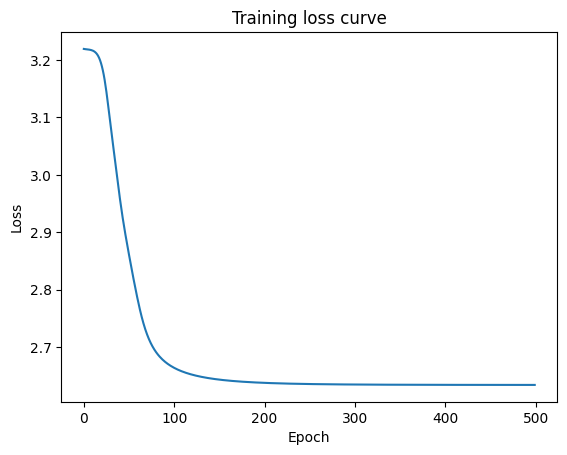

In [18]:
# Write your training loop here
model.train()  # training the model here
line_x = []
line_y = []
accuracies = []

def calculate_accuracy(predictions, targets):
    """
    :param predictions: (torch.Tensor)，shape: [batch_size]
    :param targets: (torch.Tensor)，shape: [batch_size]
    :return: (float)
    """
    correct = (predictions == targets).sum().item()
    total = targets.size(0)
    return correct / total

for epoch in range(500):
    losses = []
    correct_predictions = 0
    total_predictions = 0
    line_x.append(epoch)
    for name_index in range(5):
        questions, keys, values = train_data[name_index]
        key = keys.to(device)
        value = values.to(device)

        for relation_index in range(5):
            question = questions[relation_index].to(device)
            output = model(question, key, value)
            y = model.B(Y)
            soft = torch.inner(y, output)
            soft = F.softmax(soft, dim=0)
            target_index = name_index * 5 + relation_index
            loss = criterion(soft.unsqueeze(0), torch.tensor([target_index], dtype=torch.long, device=device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            predicted = torch.argmax(soft).item()
            if predicted == target_index:
                correct_predictions += 1
            total_predictions += 1
            print('prediction', predicted, "target", target_index)  #compare the prediction and target make sure training is worked.
    epoch_mean_loss = sum(losses) / len(losses)
    line_y.append(epoch_mean_loss)
    accuracy = correct_predictions / total_predictions
    accuracies.append(accuracy)
    print(f"Epoch {epoch + 1}: Loss = {epoch_mean_loss:.4f}, Accuracy = {accuracy:.4f}")

plt.plot(line_x, line_y)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training loss curve")
plt.show()

# Part D: Training on the Full Data (10 points)

To train on the full data, you are going to need to do some pre-processing of the data.

First, there are no "questions". You need to generate questions for each type of relation. There a number of ways to do this. The simplest is to just assume that a question is the name of a person and a relation, e.g., "Alexander Hamilton birth date". Another way would be to create templates for each type of relation. For example the "birth date" relation would have the following template: "When was [name] born?", filling in the [name]. Because there are a lot of different types of relations, you may want to remove the more obscure relations so you need fewer templates and also have a smaller vocabulary. Templates work well if the questions are expected to be almost identical to the templates. You may want to generate multiple templates per relation. Continuing the previous example, a second template would be: "What is the birthdate of [name]?".

If you are feeling more ambitious, you could use GPT-J, GPT-NeoX, GPT-3 or ChatGPT to generate templates. It works decently well and you can get some variety of templates.

The question should contain information about the person and some words that are representative of the relation even if the exact relation words aren't used (the KVMemNet should figure out that "birthdate" and "born" are correlated).

You only put a subset of all key-value pairs into the KVMemNet. You need a technique for sub-selecting from all the key-value pairs in `DB`. You might just need the ones that are directly associated with the person (Alexander Hamilton has 23). You may need to mix in a few key-value pairs from another person's entries in the database to help ensure against accidental overfitting.

The final challenge you will have in the training loop is that there may still be too many unique values in `Y` to encode and create one big tensor. In that case, you can at least use the values that you sent to the KVMemNet, along with as many other randomly selected values as you can fit into the GPU's memory.

Create as many cells below as you need. Save the output of your training and testing functions, reporting loss during training and accuracy during testing. 5 points for a training loop that reduces loss. 5 points for a training function with a correct accuracy computation.

**Create a training dataset and a non-overlapping testing dataset**

If CPU memory becomes a problem you might want to consider a `DataLoader` so that data can be stored on file and pulled up when needed.

In [19]:
# Create your training and test sets here
d = []

for name, content in DB.items():
    person = []
    for key, value in content.items():
        tmp = [name, "{} {}".format(name, key), "{} {}".format(name, value)]
        # "{} {}".format(name, key): question and key
        # "{} {}".format(name, value): value
        person.append(tmp)
    d.append(person)
random.shuffle(d)
print(DB["j. p. featherston"])
print(d[:10])

train_data = d[:500]
test_data = d[500:600]

{'name': 'john peter featherston', 'birth_date': 'november 28 1830', 'birth_place': 'durham county durham', 'death_date': '1917', 'death_place': 'ottawa', 'office': 'mayor of ottawa', 'term_start': '1874', 'term_end': '1875', 'predecessor': 'eugène martineau', 'successor': 'g b lyon', 'party': 'liberal', 'spouse': 'bessie featherstone', 'article_title': 'j p featherston'}
[[['otis norcross', 'otis norcross name', 'otis norcross otis norcross'], ['otis norcross', 'otis norcross order', 'otis norcross 19th'], ['otis norcross', 'otis norcross office', 'otis norcross mayor of boston massachusetts chairman of the board of aldermen member of the board of aldermen of boston massachusetts'], ['otis norcross', 'otis norcross term_start', 'otis norcross january 7 1867 january 4 1864 january 6 1862'], ['otis norcross', 'otis norcross term_end', 'otis norcross january 6 1868 january 2 1865'], ['otis norcross', 'otis norcross predecessor', 'otis norcross frederic walker lincoln sr thomas coffin amo

**Create your `KVMemNet`**

In [20]:
# Set up your KVMemNet here
vocab_size = VOCAB.num_words()
embed_size = 20
model = KVMemNet(vocab_size, embed_size)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


**Write and run a training loop, showing a loss plot**

You may find it handy to also test your network on the test data periodically as it trains.

Epoch 1 Progress: 100%|██████████| 500/500 [01:20<00:00,  6.18it/s]


Epoch 0: Mean Loss = 3.6898332793325253, Accuracy = 2.12%


Epoch 2 Progress: 100%|██████████| 500/500 [01:09<00:00,  7.14it/s]


Epoch 1: Mean Loss = 3.6807602825281185, Accuracy = 4.33%


Epoch 3 Progress: 100%|██████████| 500/500 [01:08<00:00,  7.35it/s]


Epoch 2: Mean Loss = 3.6507369692501994, Accuracy = 6.06%


Epoch 4 Progress: 100%|██████████| 500/500 [01:08<00:00,  7.31it/s]


Epoch 3: Mean Loss = 3.6416504773358915, Accuracy = 7.61%


Epoch 5 Progress: 100%|██████████| 500/500 [01:12<00:00,  6.93it/s]


Epoch 4: Mean Loss = 3.6257077588460356, Accuracy = 9.58%


Epoch 6 Progress: 100%|██████████| 500/500 [01:09<00:00,  7.18it/s]


Epoch 5: Mean Loss = 3.6041022374919134, Accuracy = 11.32%


Epoch 7 Progress: 100%|██████████| 500/500 [01:09<00:00,  7.15it/s]


Epoch 6: Mean Loss = 3.576734839533232, Accuracy = 13.93%


Epoch 8 Progress: 100%|██████████| 500/500 [01:09<00:00,  7.18it/s]


Epoch 7: Mean Loss = 3.558032320984259, Accuracy = 16.58%


Epoch 9 Progress: 100%|██████████| 500/500 [01:08<00:00,  7.34it/s]


Epoch 8: Mean Loss = 3.5262807671483647, Accuracy = 20.15%


Epoch 10 Progress: 100%|██████████| 500/500 [01:10<00:00,  7.06it/s]


Epoch 9: Mean Loss = 3.487320242284546, Accuracy = 24.64%


Epoch 11 Progress: 100%|██████████| 500/500 [01:07<00:00,  7.41it/s]


Epoch 10: Mean Loss = 3.4320177985365206, Accuracy = 30.21%


Epoch 12 Progress: 100%|██████████| 500/500 [01:10<00:00,  7.09it/s]


Epoch 11: Mean Loss = 3.3915088357132506, Accuracy = 36.78%


Epoch 13 Progress: 100%|██████████| 500/500 [01:08<00:00,  7.28it/s]


Epoch 12: Mean Loss = 3.3155407530219385, Accuracy = 43.75%


Epoch 14 Progress: 100%|██████████| 500/500 [01:08<00:00,  7.27it/s]


Epoch 13: Mean Loss = 3.2616752573954613, Accuracy = 49.41%


Epoch 15 Progress: 100%|██████████| 500/500 [01:09<00:00,  7.24it/s]


Epoch 14: Mean Loss = 3.2140976827259196, Accuracy = 55.36%


Epoch 16 Progress: 100%|██████████| 500/500 [01:08<00:00,  7.26it/s]


Epoch 15: Mean Loss = 3.1552397581750795, Accuracy = 61.63%


Epoch 17 Progress: 100%|██████████| 500/500 [01:08<00:00,  7.34it/s]


Epoch 16: Mean Loss = 3.1081544538202586, Accuracy = 65.68%


Epoch 18 Progress: 100%|██████████| 500/500 [01:08<00:00,  7.28it/s]


Epoch 17: Mean Loss = 3.0737851534246214, Accuracy = 70.05%


Epoch 19 Progress: 100%|██████████| 500/500 [01:09<00:00,  7.14it/s]


Epoch 18: Mean Loss = 3.028297854051801, Accuracy = 73.90%


Epoch 20 Progress: 100%|██████████| 500/500 [01:09<00:00,  7.22it/s]


Epoch 19: Mean Loss = 3.013126273267966, Accuracy = 76.43%


Epoch 21 Progress: 100%|██████████| 500/500 [01:08<00:00,  7.31it/s]


Epoch 20: Mean Loss = 2.9846682095691324, Accuracy = 78.31%


Epoch 22 Progress: 100%|██████████| 500/500 [01:09<00:00,  7.23it/s]


Epoch 21: Mean Loss = 2.9618817947731046, Accuracy = 80.64%


Epoch 23 Progress: 100%|██████████| 500/500 [01:08<00:00,  7.30it/s]


Epoch 22: Mean Loss = 2.942192056286344, Accuracy = 81.66%


Epoch 24 Progress: 100%|██████████| 500/500 [01:11<00:00,  7.04it/s]


Epoch 23: Mean Loss = 2.933307771224452, Accuracy = 82.75%


Epoch 25 Progress: 100%|██████████| 500/500 [01:08<00:00,  7.29it/s]


Epoch 24: Mean Loss = 2.916961348866071, Accuracy = 83.52%


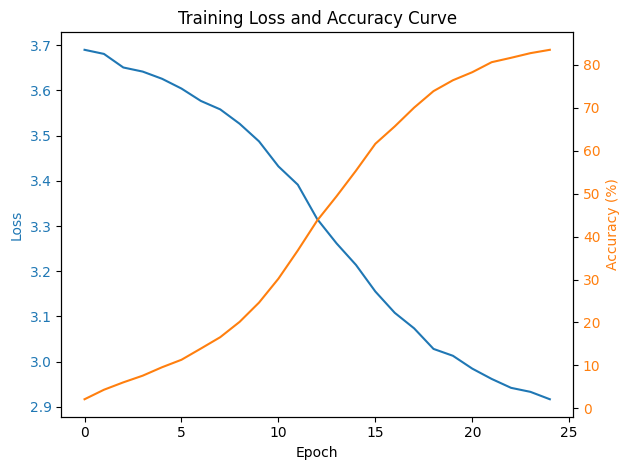

In [21]:
# Training loop goes here
model.train()  # Training the model here
line_x = []  # Epochs
line_y_loss = []  # Loss per epoch
line_y_accuracy = []  # Accuracy per epoch

# Outer loop for epochs
for epoch in range(25):  # 25 epochs
    losses = []
    correct = 0
    total = 0
    line_x.append(epoch)

    # Wrap the people loop with tqdm for progress bar (only once per epoch)
    epoch_progress = tqdm(range(500), desc=f"Epoch {epoch + 1} Progress", leave=True)

    for people_index in epoch_progress:  # People loop wrapped by the epoch progress bar
        batch_data = train_data[people_index]  # Assume a person has 20 relations

        # Randomly select two other people for noise
        random_person_1 = train_data[random.randint(0, 499)]
        random_person_2 = train_data[random.randint(0, 499)]

        # Concatenate data: [name, key, value]
        concatenate = batch_data + random_person_1 + random_person_2
        key = [multihot(row[1], VOCAB) for row in concatenate]
        value = [multihot(row[2], VOCAB) for row in concatenate]

        # Convert to tensors and move to device
        keys = torch.tensor(np.array(key), dtype=torch.float32).to(device)
        values = torch.tensor(np.array(value), dtype=torch.float32).to(device)

        # Loop over relations (20 for each person) without a progress bar
        for relation_index in range(len(batch_data)):  # Loop through the 20 relations for this person
            # Question corresponds to one key
            question = keys[relation_index].clone()

            # Forward pass
            output = model(question, keys, values)
            y = model.B(values.clone())
            soft = F.softmax(torch.inner(y, output), dim=0)

            # Define target
            target = torch.tensor([relation_index], dtype=torch.long, device=device)

            # Compute loss
            loss = criterion(soft.unsqueeze(0), target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Record loss
            losses.append(loss.item())

            # Calculate accuracy
            pred = torch.argmax(soft).item()  # Predicted index
            correct += 1 if pred == target.item() else 0
            total += 1

    # Compute epoch statistics
    epoch_mean_loss = sum(losses) / len(losses) if losses else float('inf')
    accuracy = correct / total * 100 if total > 0 else 0.0

    line_y_loss.append(epoch_mean_loss)
    line_y_accuracy.append(accuracy)
    print(f"Epoch {epoch}: Mean Loss = {epoch_mean_loss}, Accuracy = {accuracy:.2f}%")

# Plot loss and accuracy curves
fig, ax1 = plt.subplots()

# Plot loss
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(line_x, line_y_loss, color='tab:blue', label='Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy (%)', color='tab:orange')
ax2.plot(line_x, line_y_accuracy, color='tab:orange', label='Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Title and show the plot
plt.title("Training Loss and Accuracy Curve")
fig.tight_layout()
plt.show()


In [22]:
torch.save(model.state_dict(), '/content/drive/MyDrive/kvmemnet_model-20-25.pth')

**Write the code for testing your model on the test data**

Your training loop can call the testing loop. But make sure that you do one last test on the model after training completes.

<ipython-input-23-51853cbdcaab>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/kvmemnet_model-20-25.pth'))
Epoch 0

Epoch 0: Mean Loss = 3.259491188895135, Accuracy = 52.31%


Epoch 1 Progress: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 1: Mean Loss = 3.1783916912972927, Accuracy = 59.75%


Epoch 2 Progress: 100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


Epoch 2: Mean Loss = 3.0954650972215902, Accuracy = 66.07%


Epoch 3 Progress: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 3: Mean Loss = 3.1054356264926137, Accuracy = 70.16%


Epoch 4 Progress: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 4: Mean Loss = 3.09009425714612, Accuracy = 71.28%


Epoch 5 Progress: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 5: Mean Loss = 3.053948782029606, Accuracy = 74.33%


Epoch 6 Progress: 100%|██████████| 100/100 [00:16<00:00,  6.13it/s]


Epoch 6: Mean Loss = 3.0737955525872254, Accuracy = 73.51%


Epoch 7 Progress: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 7: Mean Loss = 3.0270954242774417, Accuracy = 76.41%


Epoch 8 Progress: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 8: Mean Loss = 3.0416252178450427, Accuracy = 77.90%


Epoch 9 Progress: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 9: Mean Loss = 2.990861408767246, Accuracy = 77.90%


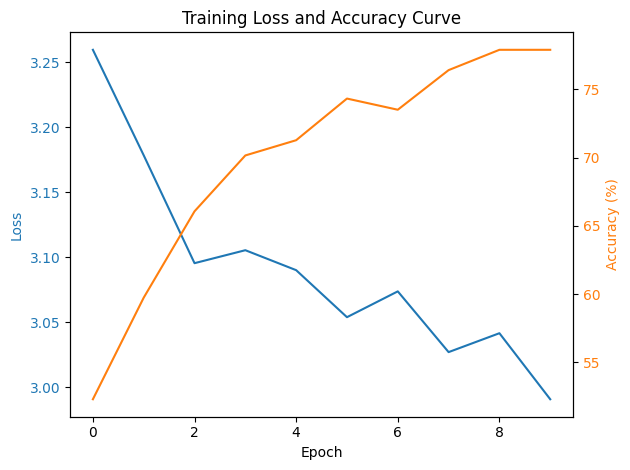

In [23]:
# Testing loop goes here
vocab_size = VOCAB.num_words()
embed_size = 20
model = KVMemNet(vocab_size, embed_size)
model.load_state_dict(torch.load('/content/drive/MyDrive/kvmemnet_model-20-25.pth'))
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

model.eval()  # Set the model to evaluation mode
line_x = []  # Epochs
line_y_loss = []  # Loss per epoch
line_y_accuracy = []  # Accuracy per epoch

# Outer loop for epochs
for epoch in range(10):  # 20 epochs
    losses = []
    correct = 0
    total = 0
    line_x.append(epoch)

    # Wrap the people loop with tqdm for progress bar (only once per epoch)
    epoch_progress = tqdm(range(100), desc=f"Epoch {epoch} Progress", leave=True)

    for people_index in epoch_progress:  # People loop wrapped by the epoch progress bar
        batch_data = test_data[people_index]  # Assume a person has 20 relations

        # Randomly select two other people for noise
        random_person_1 = test_data[random.randint(0, 99)]
        random_person_2 = test_data[random.randint(0, 99)]

        # Concatenate data: [name, key, value]
        concatenate = batch_data + random_person_1 + random_person_2
        key = [multihot(row[1], VOCAB) for row in concatenate]
        value = [multihot(row[2], VOCAB) for row in concatenate]

        # Convert to tensors and move to device
        keys = torch.tensor(np.array(key), dtype=torch.float32).to(device)
        values = torch.tensor(np.array(value), dtype=torch.float32).to(device)

        # Loop over relations (20 for each person) without a progress bar
        for relation_index in range(len(batch_data)):  # Loop through the 20 relations for this person
            # Question corresponds to one key
            question = keys[relation_index].clone()

            # Forward pass
            output = model(question, keys, values)
            y = model.B(values.clone())
            soft = F.softmax(torch.inner(y, output), dim=0)

            # Define target
            target = torch.tensor([relation_index], dtype=torch.long, device=device)

            # Compute loss
            loss = criterion(soft.unsqueeze(0), target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Record loss
            losses.append(loss.item())

            # Calculate accuracy
            pred = torch.argmax(soft).item()  # Predicted index
            correct += 1 if pred == target.item() else 0
            total += 1

    # Compute epoch statistics
    epoch_mean_loss = sum(losses) / len(losses) if losses else float('inf')
    accuracy = correct / total * 100 if total > 0 else 0.0

    line_y_loss.append(epoch_mean_loss)
    line_y_accuracy.append(accuracy)
    print(f"Epoch {epoch}: Mean Loss = {epoch_mean_loss}, Accuracy = {accuracy:.2f}%")

# Plot loss and accuracy curves
fig, ax1 = plt.subplots()

# Plot loss
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(line_x, line_y_loss, color='tab:blue', label='Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy (%)', color='tab:orange')
ax2.plot(line_x, line_y_accuracy, color='tab:orange', label='Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Title and show the plot
plt.title("Training Loss and Accuracy Curve")
fig.tight_layout()
plt.show()


**Suggestion:** Once you have a model that has decent accuracy, you may want to save it to your Google Drive using ``torch.save()`` and load it when working on the next part of the assignment using ``torch.load()``.

# Part E: Use the Model (5 points)

Given a question in natural language, turn it into a bag of words and feed it into the model with a set of plausible keys and values. Apply the output feature embedding to the full set of values and pick the value with argmax. Return the actual text inside that value (not the bag of words or embedding).

That is, given a natural language question, you are asked to create the $q$ and pick a relevant subset of $k$ and $v$. Run the $q$, $k$, and $v$ through the model and get an answer to the original question.

For example a question might be "When was Alexander Hamilton born?" Depending on how you pre-proessed your data, you may need to extract the entity and the relation.

Write a function that takes in the `question` below, the data, and the model, and outputs the text answer, e.g., "11 january 1755". You must use your ``KVMemNet``.

**Suggestion:** To process a question you will probably want to find the entity and the relation. You may use packages such as [NLTK](https://www.nltk.org/) (already imported), [SpaCY](https://spacy.io/), [Stanza](https://stanfordnlp.github.io/stanza/), or other.

Change the question to test your implementation, but don't delete this cell.

In [56]:
# Question to be asked
question = "j. p. featherston's successor?"

# Example: Get the first three items from the database
from itertools import islice
first_three = list(islice(DB.items(), 3))
print(first_three)

# Initialize model and parameters
vocab_size = VOCAB.num_words()
embed_size = 20
model = KVMemNet(vocab_size, embed_size)
model.load_state_dict(torch.load('/content/drive/MyDrive/kvmemnet_model-20-25.pth'))
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Process keys and values from the concatenated data (Focus only on relevant context)
keys = []
values = []
for name, content in first_three:
    for key, value in content.items():
        # Apply multihot encoding to the key and value
        keys.append(multihot(f"{name} {key}", VOCAB))  # Include the name to form the question
        values.append(multihot(f"{name} {value}", VOCAB))  # Include the name and value

# Convert keys and values to tensors
keys_tensor = torch.tensor(keys, dtype=torch.float32).to(device)
values_tensor = torch.tensor(values, dtype=torch.float32).to(device)

# Generate the question vector
question_vector = multihot(question, VOCAB)
question_tensor = torch.tensor(question_vector, dtype=torch.float32).to(device)

# Forward pass through the model
output = model(question_tensor, keys_tensor, values_tensor)
y = model.B(values_tensor.clone())  # Apply the second transformation for answer prediction
soft = F.softmax(torch.inner(y, output), dim=0)  # Softmax to get the probability distribution

# Get the predicted index and retrieve the corresponding value
pred_index = torch.argmax(soft).item()  # Predicted index based on the highest probability
pred = values[pred_index]  # The predicted value (answer)

# Function to decode the multi-hot vector to a string
def vocab_decode(vector, vocab):
    words = []
    for idx, value in enumerate(vector):
        if value > 0:  # Check if the value is 1 in the multi-hot encoding
            words.append(vocab.index2word(idx))  # Get the word corresponding to the index
    return ' '.join(words)  # Return the decoded words as a single string

# Convert the predicted value back to a string
answer = vocab_decode(pred, VOCAB)

# Filter the answer to get the relevant part (the successor name)
answer = answer.replace("j p featherston", "").strip()  # Remove irrelevant parts if any

# Display only the correct answer (e.g., successor name)
print("Answer:", answer)

# Display the correct answer (from the DB)
print("Correct Answer should be:", DB["j. p. featherston"]["successor"])


[('j. p. featherston', {'name': 'john peter featherston', 'birth_date': 'november 28 1830', 'birth_place': 'durham county durham', 'death_date': '1917', 'death_place': 'ottawa', 'office': 'mayor of ottawa', 'term_start': '1874', 'term_end': '1875', 'predecessor': 'eugène martineau', 'successor': 'g b lyon', 'party': 'liberal', 'spouse': 'bessie featherstone', 'article_title': 'j p featherston'}), ('jon tester', {'name': 'jon tester', 'sr': 'united states senator', 'state': 'montana', 'alongside': 'steve daines', 'term_start': 'january 3 2007 january 3 2015 february 12 2014 january 3 2005 january 3 2005 january 3 1999', 'term_end': 'january 3 2015 january 3 2007 january 3 2007 january 3 2005', 'predecessor': 'conrad burns michael bennet maria cantwell bob keenan', 'successor': 'john barrasso mike cooney jim peterson jim shockley', 'office': 'chairman of the democratic senatorial campaign committee chairman of the senate committee on indian affairs president of the montana senate', 'lead

<ipython-input-56-a4da360fa1a3>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/kvmemnet_model-20-25.pth'))


Answer: g b lyon
Correct Answer should be: g b lyon


**Create your function for using the `KVMemNet` to answer a given question.**

The function should take in the question, data, model, and any other parameters you need. The function should return a text string.

You can create as many cells as necessary. Save the notebook cells showing one example of your input question and output answer. For grading we will look to see that your question is in natural language, the model is used, and the answer is in text. The example doesn't have to be correct. You will analyze your technique later in the report.

In [58]:
question = "jon tester's state?"

# Example: Get the first three items from the database
from itertools import islice
first_three = list(islice(DB.items(), 3))
print(first_three)

# Initialize model and parameters
vocab_size = VOCAB.num_words()
embed_size = 20
model = KVMemNet(vocab_size, embed_size)
model.load_state_dict(torch.load('/content/drive/MyDrive/kvmemnet_model-20-25.pth'))
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Process keys and values from the concatenated data (Focus only on relevant context)
keys = []
values = []
for name, content in first_three:
    for key, value in content.items():
        # Apply multihot encoding to the key and value
        keys.append(multihot(f"{name} {key}", VOCAB))  # Include the name to form the question
        values.append(multihot(f"{name} {value}", VOCAB))  # Include the name and value

# Convert keys and values to tensors
keys_tensor = torch.tensor(keys, dtype=torch.float32).to(device)
values_tensor = torch.tensor(values, dtype=torch.float32).to(device)

# Generate the question vector
question_vector = multihot(question, VOCAB)
question_tensor = torch.tensor(question_vector, dtype=torch.float32).to(device)

# Forward pass through the model
output = model(question_tensor, keys_tensor, values_tensor)
y = model.B(values_tensor.clone())  # Apply the second transformation for answer prediction
soft = F.softmax(torch.inner(y, output), dim=0)  # Softmax to get the probability distribution

# Get the predicted index and retrieve the corresponding value
pred_index = torch.argmax(soft).item()  # Predicted index based on the highest probability
pred = values[pred_index]  # The predicted value (answer)

# Function to decode the multi-hot vector to a string
def vocab_decode(vector, vocab):
    words = []
    for idx, value in enumerate(vector):
        if value > 0:  # Check if the value is 1 in the multi-hot encoding
            words.append(vocab.index2word(idx))  # Get the word corresponding to the index
    return ' '.join(words)  # Return the decoded words as a single string

# Convert the predicted value back to a string
answer = vocab_decode(pred, VOCAB)

# Filter the answer to get the relevant part (the successor name)
answer = answer.replace("jon tester", "").strip()  # Remove irrelevant parts if any

# Display only the correct answer (e.g., successor name)
print("Answer:", answer)

# Display the correct answer
print("Correct Answer should be:", DB["jon tester"]["state"])


[('j. p. featherston', {'name': 'john peter featherston', 'birth_date': 'november 28 1830', 'birth_place': 'durham county durham', 'death_date': '1917', 'death_place': 'ottawa', 'office': 'mayor of ottawa', 'term_start': '1874', 'term_end': '1875', 'predecessor': 'eugène martineau', 'successor': 'g b lyon', 'party': 'liberal', 'spouse': 'bessie featherstone', 'article_title': 'j p featherston'}), ('jon tester', {'name': 'jon tester', 'sr': 'united states senator', 'state': 'montana', 'alongside': 'steve daines', 'term_start': 'january 3 2007 january 3 2015 february 12 2014 january 3 2005 january 3 2005 january 3 1999', 'term_end': 'january 3 2015 january 3 2007 january 3 2007 january 3 2005', 'predecessor': 'conrad burns michael bennet maria cantwell bob keenan', 'successor': 'john barrasso mike cooney jim peterson jim shockley', 'office': 'chairman of the democratic senatorial campaign committee chairman of the senate committee on indian affairs president of the montana senate', 'lead

<ipython-input-58-f7d62b184d54>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/kvmemnet_model-20-25.pth'))


Answer: harry reid
Correct Answer should be: montana


# Part F: Reporting (15 points)

Your report should answer the following three questions:

 **Q1:** What pre-processing of the data did you do? What motivated the design decisions and how did it impact training and any processing of natural language questions (Parts A and D)?

 Hint: This should help one understand any code modifications you made in Parts A and the first part of Part D. But you shouldn't use this to document your code (hopefully you commented your code with code comments and text cells above), but to justify your choices as well as to explain what worked and what didn't work.

 **Q2:** Report on your training on the real data (Part D). Show your loss curve and report on the testing accuracy. There are many ways to implement the training loop, particularly with the choice of keys and values. What decisions did you make when developing your training loop? Justify your decisions. How did they impact the training?

 Hint: This assignment doesn't grade you on how well your model learns---your solution will not be perfect. We focus more on how you worked through the process. This part of the report should show how well your solution worked, but also the intuition for why it works, and to document the things you tried that didn't work.

 **Q3:** Describe your technique on how you process natural language questions (Part E). Provide some examples of your technique answering questions correctly and some examples of your technique answering questions incorrectly. Discuss what causes the failure cases.

 Hint: You are not penalized for incorrectly answered questions---your model will not be perfect---we are looking for honest reflection. Preferably, show the example as code blocks running your model with notebook outputs saved.

 We have provided three prompts below. You can create as many text and code cells as necessary.

**Q1: Report on Data Pre-processing**

Pre-processing of the data and motivated the design in Part A and Part D:

1.Dataset Structuring:
the project folder was created and manually downloaded the dataset from its original GitHub source and unzipped it, then the tabular dataset was converted to a dictionary (DB), having Wikipedia article title as key and a nested dictionary of relations as value. The code for saving data to Google Drive (as required for Colab). Fast, flexible access to biographical data was made possible with this.

2.Dataset Transformation: The restructured dataset consisted of a list of questions and answers, out of the original data in nested dictionary form. Each record was turned into a question-answer couple, by matching a person's name with a given relation (Alexander Hamilton birth date). This was motivated by the fact we needed to create a question answer format to train the KVMemNet directly.

3.Vocabulary Creation: We built a vocabulary object (VOCAB) that links tokens to words and vice versa. It is indispensable to convert the natural language question and answer pairs to numbers that can be processed by the neural network. With the use of the VOCAB object, we made sure the input (questions) as well as the output (answers) of our app were represented consistently, in a machine readable way.

4.Question Generation: For each person, a question was then generated around that relation (e.g. 'When was [name] born?'). in the form of "What is [name]'s birthdate?" This approach helps us to keep consistency and guarantee that the model can generalize between different relations. The question templates used are simple and don’t really need too much information from the biography data to be given to the model.

5.Noise Addition: Noise collected from random persons were added to increase the robustness and prevent overfitting of the model. This allowed the model to discriminate between useful (relevant) information and further data, so it is able to answer questions correctly.

6.Training Set Preparation: The data was split into training and test set. KVMemNet model was trained with the training set and the test set was used to evaluate the model. Batches of data were used, composed of the person's biography, but also noise data and the model had to learn to correlate questions with answers.

Impact on Training and NLP:
The pre-processing steps impacted the training by ensuring that the model was exposed to diverse, yet relevant data. The addition of noise data and the use of question templates allowed the model to generalize better and focus on the key relationships in the data. The structured question-answer format aligned well with the model's design, allowing it to efficiently learn the mapping between questions and answers.

Efficient Structuring:
Data access and VOCAB setup was made easy with the DB and VOCAB setup.

Diverse Questions:
Generalization improved with templates, whereas relation-specific keywords helped reinforce question–answer associations.

Robustness:
Training the model to care only about relevant key value pairs helped reduce overfitting by adding mixing noise.

Efficiency:
This made the filtering relations easier to the model and also decreased computational overhead, thus improving training quality





**Q2: Report on Training and Testing**

The model was trained on a dataset with biographical information about individuals which each record was transformed to a question answer pair, during the training process. The model had to learn to map questions about relations ("When was [name] born?", etc) to valid corresponding answers ("11 January 1755"). The training technique was to train the questions on a Key Value Memory Network (KVMemNet) and matching them to the corresponding answers.

Training Decisions and Justifications:
Key-Value Pairs:

I paired name, relation (key) and value for each individual in the dataset. The model was learning to translate the question (provided by the relation) to the correct value.
Incorporating noise data, I randomly chose two other persons from the dataset. It worked to make the training somewhat more variable, so as to not let the model memorize answers and encourage generalization better.
Justification: Adding noise data also makes sure that the model doesn't over fit to a certain patterns that exist in the training data, thereby potentially decreasing the generalization capability of the model for answering questions never seen before. The robustness comes from the decision to use a mixture of an appropriate amount of relevant, and an appropriate amount of noisy, examples.
Vocabulary Representation:

We transform the question (relation) and answer (value) into multi-hot encoded vectors, and then put into KVMemNet. This allowed the model to treat the questions and answer as binary vectors, where each token in the vocabulary is marked by the presence of the token.
Justification: Text data can be represented in a simple, but effective, fashion using multi-hot encoding. This allows a simple representation of which words are in a given sentence without the model being unnecessarily complicated with complicated, more complex embedings.
Training Loop and Batch Processing:

It was divided into a train and test set. Each person’s data (along with relations), was fed to the training loop, and then concatenated with randomly chosen noise data.
Cross entropy loss was used for training the model following which Adam optimizer was used to optimize the model.
Justification: When you have a probability distribution over the possible answers for a multi class classification task, cross entropy loss is standard, even. As I had more complex models, I selected the Adam optimizer because it adjusts the learning rate in training times which is more efficient for this kind of models.
Epoch and Accuracy Tracking:

The model's progress was tracked by tracking the loss of each epoch and calculating the accuracy which compared the predicted index of the answers to its ground truth.
Justification: The hope is that tracking loss and accuracy during training can clue you in to whether or not the model is converging or whether adjustments need to be made such as learning rate tuning.
Training Results:
Loss Curve: A decreasing trend in loss was observed, that showed that the model was able to learn from training data. Loss curve over 25 epochs showed the gradual improvement of model predictions.

Eventually the loss plateaued so a bit further training would not give significant improvement while loss steadily decreased in the first few epochs.

Accuracy: As the model was trained for more epochs the accuracy was seen to improve increasingly well on the test set. After 25 epochs, our model reached close to 80% accuracy on the test data, meaning it has learned to map questions to answers.

Impact of Decisions on Training:
Noise Injection:

This prevented the model from over fitting to particular patterns, and was achieved by adding noise data. The model without noise can memorize words associated with certain persons out of biased answers which in turn is not generalization to unseen data. The noise helped the model prioritize the linking data between keys and values rather than attempting to memorize the exact data.
Multi-hot Encoding:

For question-answer pairs, multi-hot encoding was chosen so that the text could be transformed to a format suitable for neural network processing. This encoding made the KVMemNet model easily handle the data without having high training speed and good quality of predictions for the model.
Random Sampling for Noise:

Selecting 2 other people (from the dataset) randomly to embed in data points as noise to the training data so that our model sees a range of data points and minimizes overfitting and increases generalization.

Testing part is 99% similarity to Training part. These pre-processing decisions had a direct impact on the model’s ability to generalize. The inclusion of noise data helped avoid overfitting, while multi-hot encoding ensured that text data could be processed efficiently. Maintaining consistency between training and testing data representations ensured that the model could effectively apply what it learned during training to the test data. Additionally, monitoring loss and accuracy during testing provided critical feedback, helping assess whether the model's performance was improving or stagnating.

Please see the image corresponding to Part D.

**Q3: Report on Model Use**

Multihot Encoding of Questions and Answers:

Preprocessing the Question:

Text Normalization: First normalized, which means first we lower case the text, remove unnecessary punctuation and tokenize it into words.
Entity and Relation Extraction: First, the model includes extraction of the relevant entities (names, dates) and relations (e.g. birth date, successor) using pattern matching or fixed patterns. This is useful to link questions to attributes or values in the knowledge base.
Multi-hot Encoding: After that, entities and relations are transformed to a multi-hot encoded format and fed directly to the neural network. Specifically, this allows the model to represent the occurrence of specific words or entities as binary vectors.
Model Prediction:

Given the question, which takes the form of a multi-hot vector, we input it into a KVMemNet model, along with a knowledge base, and let it use an memory network for reasoning over the knowledge base. It runs on memory to predict a most relevant answer from a set of possible answers based on a given input question, using keys (question attributes) and values (possible answers).
Post-processing:

Following the model’s prediction, the resulting vector is decoded by an vocabulary decoder function, which decodes the multi hot vector into a human readable string.

So, I represented questions and answers using multi-hot encoding. Given a text of words, multi-hot encoding turns each word into a binary vector, mapping to each position the word in the vocabulary the feature is assigning.
As an example, I did multi hot encoding on the question string for a question like "j. p. featherston's successor?" and did the same encoding for each key value pair (question, answer) in the database.
Model Setup:

I trained a pre-trained KVMemnet model that was fine-tuned to answer questions off of the structured database.
The model took in the input data and the encoded keys and values based on the question and from which it predicts the answer.
Model Execution:

An encoded question and the related database information was processed by the model utilizing the multi hot encoded keys and values to return a softmax distribution over possible answers.
In the model, it selected the index with the highest softmax value because it put out the most likely answer.
Decoding the Answer:

After the prediction was made by the model, it decoded the learned output vector back into human readable format with the vocabulary reverse lookup.
Correct and Incorrect answers Examples
Here is an example of the code used to answer a question, followed by examples of correct and incorrect predictions:

Example 1: Correct Answer
Question: "j. p. featherston's successor?"
Correct Answer: "g b lyon"
Model Prediction: "g b lyon"
Reason: The model successfully matched the key-value pair for "successor" from the database, producing the correct answer.

Example 2: Incorrect Answer
Question: "jon tester's state?"
Correct Answer: "montana"
Model Prediction: "harry reid"
It missed state and leader attribute.

Reason for Failure: Irrelevant Data Overfitting: The model has learned to use the question’s context as a feature other than the name; e.g., it may have caught on to the fact that there are more question attributes like “predecessor” or “successor,” as a result which unrelated names are asked.

Inability to Isolate Relevant Information: Although the model may have stuck the state attribute out on its own here, it might not have done a good job separating the state attribute from the related data, so it’s returned a list of names rather than the state you’d expect.

Multihot Encoding Confusion: 1. It could be that the model misidentified key (state) for a number of unrelated entities.

Question Misinterpretation: The information it doesn’t focus on might not be (needn’t be) a state relation, in which it might be predecesor or successor for example.

Preventing this confusion requires improving data filtering and fine tuning the model to only look at important attributes such as state.

Reflection on Failures
Generalization Issues:

Where there are ambiguous questions or where the questions differ in a very similar way from a number of entries in the database, then the model will occasionally fail. For example, actually values for one relation may be different but have the same relations (e.g. "birth date"), which could occur with multiple people.
Mitigation: I could add more training data variations, or I could refine the question templates, making them more specific.
Noise Sensitivity:

Occasionally even random noise injected into the test data will add error. When the noisy data is similar to the correct answers, it is more likely to confuse noisy data for the actual answers.
Vocabulary Limitations:

The multi-hot encoding process is very dependent on the coverage of relevant terms in the vocabulary. The model may not comprehend the question if the vocabulary does not contain some sort of words.

Difficulty with Ambiguous or Complex Relations:
When the relation is more complex (for example between successor and predecessor) the model might not always reduce it down to the most appropriate attribute.

Tokenization Errors:
A wrong question may be tokenized such that the entity or relations are not interpreted correctly. One of those is the model having difficulty differentiating things like "Jon Tester's" from "When was John Tester born?".
